In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchmetrics
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pl.seed_everything(0)

Seed set to 0


0

In [16]:
# load datasets
DATA_PATH = '../data/stl-10'

class DataModule(pl.LightningDataModule):
    def __init__(self, data_path=DATA_PATH):
        super().__init__()
        self.data_path = data_path

    def prepare_data(self):
        datasets.STL10(self.data_path, split='train', download=True)
        datasets.STL10(self.data_path, split='test', download=True)

        self.data_transform = transforms.Compose([
            transforms.Resize(70), # 256
            transforms.RandomCrop(64), # 224
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        return
    
    def setup(self, stage=None):
        train = datasets.STL10(DATA_PATH, split='train', download=True, transform=self.data_transform)
        self.test = datasets.STL10(DATA_PATH, split='test', download=True, transform=self.data_transform)

        self.train, self.valid = random_split(train, lengths=[4000, 1000])

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=32)
    
    def val_dataloader(self):
        return DataLoader(self.valid, batch_size=32)
    
torch.manual_seed(0)
data_module = DataModule()

In [17]:
# VGG type dict
# int : output channnels after conv layer
# 'M' : max pooling layer

VGG_types = {
    'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13' : [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,'M', 512, 512, 512, 'M'],
    'VGG19' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512,'M', 512, 512, 512, 512, 'M']
}

In [18]:
class Vggnet(nn.Module):
    def __init__(self, model ,in_channels=3, num_classes=10, init_weights=True):
        super(Vggnet, self).__init__()
        self.in_channels = in_channels

        self.conv_layers = self.create_conv_layers(VGG_types[model])

        self.fcs = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096), # 512 * 7 * 7
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fcs(x)

        return x
    
    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [
                    nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1),
                    nn.BatchNorm2d(x),
                    nn.ReLU()
                ]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]

        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [19]:
class LightningModel(pl.LightningModule):
    def __init__(self, model, lr=0.001, num_classes=10):
        super().__init__()

        self.model = model
        self.lr = lr
        self.save_hyperparameters(ignore=['model'])
        self.train_acc = torchmetrics.Accuracy(task = 'MULTICLASS', num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task = 'MULTICLASS', num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task = 'MULTICLASS', num_classes=num_classes)

    def forward(self, x):
        return self.model(x)
    

    def _shared_step(self, batch):
        features, labels = batch
        logits = self.model(features)
        loss = F.cross_entropy(logits, labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, labels, predicted_labels
    
    def training_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)
        self.log('train_loss', loss)
        self.model.eval()
        with torch.no_grad():
            _, labels, predicted_labels = self._shared_step(batch)
        self.train_acc.update(predicted_labels, labels)
        self.log('train_acc', self.train_acc, on_epoch=True, on_step=False)
        self.model.train()
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)
        self.log('val_loss', loss)
        self.val_acc.update(predicted_labels, labels)
        self.log('val_acc', self.val_acc, on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)
        self.test_acc.update(predicted_labels, labels)
        self.log('test_acc', self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        return [optimizer], [scheduler]

In [20]:
model = Vggnet('VGG16', in_channels=3, num_classes=10, init_weights=True)
lightning_model = LightningModel(model, lr=0.001, num_classes=10)

callbacks = [ModelCheckpoint(monitor='val_acc', mode='max'),]

os.makedirs('./pl_models', exist_ok=True)
logger = CSVLogger(save_dir='./pl_models', name='alexnet_logs')

trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=callbacks,
    accelerator='auto',
    log_every_n_steps=5
)

start_time = time.time()
trainer.fit(lightning_model, data_module)

runtime = (time.time() - start_time) / 60
print(f"Training time: {runtime:.2f} minutes in total")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | Vggnet             | 39.9 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
39.9 M    Trainable params
0         Non-trainable params
39.9 M    Total params
159.752   Total estimated model params size (MB)


/Users/minkyunjung/miniforge3/envs/condavenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 125/125 [00:44<00:00,  2.84it/s, v_num=3, val_acc=0.261]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 125/125 [00:44<00:00,  2.84it/s, v_num=3, val_acc=0.261]
Training time: 7.98 minutes in total


<Axes: xlabel='Epoch', ylabel='Accuracy'>

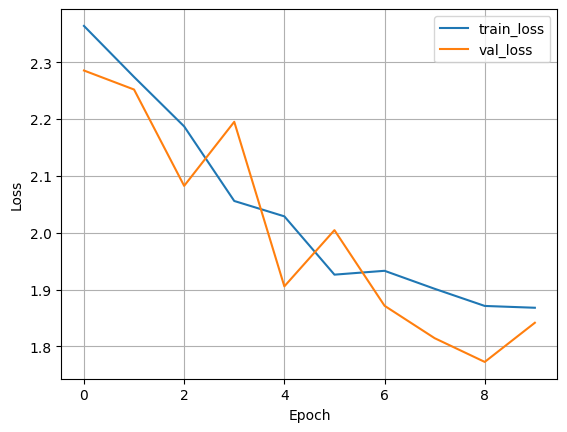

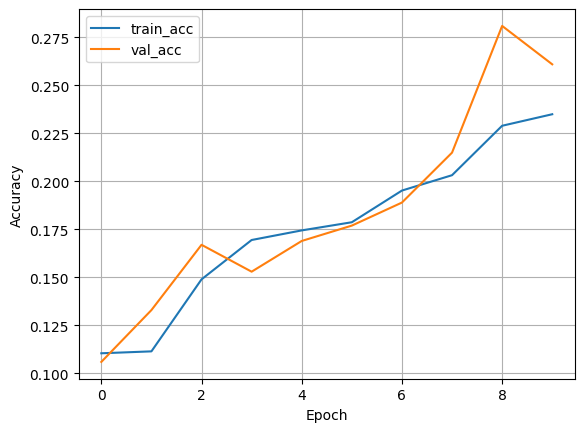

In [21]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

aggreg_metrics = []
agg_col = 'epoch'

for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[['train_loss', 'val_loss']].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics[['train_acc', 'val_acc']].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='Accuracy')